In [19]:
from fastai.vision.all import *
from duckduckgo_search import DDGS
from PIL import Image
import requests
from pathlib import Path
from fastai.vision.widgets import ImageClassifierCleaner

Aim for at least 30 images per class to improve model performance.

In [4]:
# Function to search for images
def search_images(query, max_results=30):
    with DDGS() as ddgs:
        results = ddgs.images(query, max_results=max_results)
        return [result['image'] for result in results]

In [5]:
# Function to download images
def download_images(dest, urls):
    for i, url in enumerate(urls):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Raise an error for bad responses
            img_path = dest / f'image_{i}.jpg'
            with open(img_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Failed to download {url}: {e}")

Aim for at least 30 images per class to improve model performance.

In [ ]:
# Bear types and directory setup
bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')

if not path.exists():
    path.mkdir()

for bear in bear_types:
    dest = path / bear
    dest.mkdir(exist_ok=True)
    print(f"Searching images for: {bear} bear")
    
    # Search and download images
    results = search_images(f'{bear} bear', max_results=30)
    download_images(dest, urls=results)

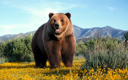

In [8]:
# Display one example image
example_image = (path / 'grizzly').glob('*.jpg')
for img_path in example_image:
    im = Image.open(img_path)
    im.thumbnail((128, 128))
    im.show()
    break  # Show only one image

To get our folder with image files

In [9]:
fns = get_image_files(path)
fns

(#78) [Path('bears/grizzly/image_27.jpg'),Path('bears/grizzly/image_11.jpg'),Path('bears/grizzly/image_13.jpg'),Path('bears/grizzly/image_24.jpg'),Path('bears/grizzly/image_6.jpg'),Path('bears/grizzly/image_18.jpg'),Path('bears/grizzly/image_4.jpg'),Path('bears/grizzly/image_3.jpg'),Path('bears/grizzly/image_29.jpg'),Path('bears/grizzly/image_10.jpg'),Path('bears/grizzly/image_16.jpg'),Path('bears/grizzly/image_0.jpg'),Path('bears/grizzly/image_15.jpg'),Path('bears/grizzly/image_8.jpg'),Path('bears/grizzly/image_14.jpg'),Path('bears/grizzly/image_19.jpg'),Path('bears/grizzly/image_2.jpg'),Path('bears/grizzly/image_12.jpg'),Path('bears/grizzly/image_23.jpg'),Path('bears/grizzly/image_22.jpg')...]

Get corrupt images

In [10]:
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/image_7.jpg')]

Removing all failed images and unlink them

In [11]:
failed.map(Path.unlink)

(#1) [None]

Turning our data into a DataLoader object

In [12]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

Command to give as our DataBlock object

In [13]:
dls = bears.dataloaders(path)

In [14]:
print(len(get_image_files(path)))  # Total images
for folder in path.ls(): 
    print(f"{folder.name}: {len(get_image_files(folder))} images")

77
grizzly: 28 images
black: 24 images
teddy: 25 images


Performing Data Augmentation

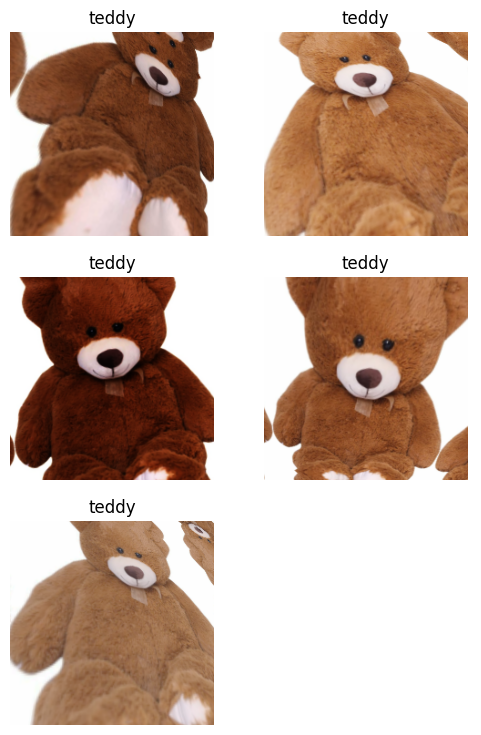

In [15]:
bears = bears.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=3, unique=True)

Create our learner and fine tune it

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.853773,2.774215,0.714286,00:04


epoch,train_loss,valid_loss,error_rate,time
0,2.217772,1.651777,0.714286,00:04
1,1.769249,0.196061,0.000000,00:04
2,1.380023,0.030401,0.000000,00:03
3,1.102671,0.015754,0.000000,00:04


We can visualize a `confusion matrix`.

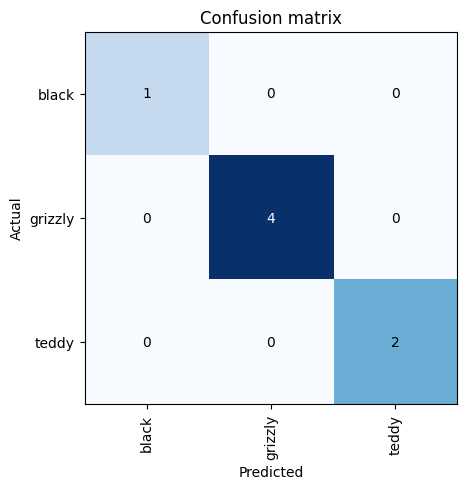

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The loss is a number that is higher if the model is incorrect(especially if its also confident of its incorrect answers), or if it's correct, but not confident of its correct answer. `plot_top_losses` shows us the images with the highest loss in our dataset.

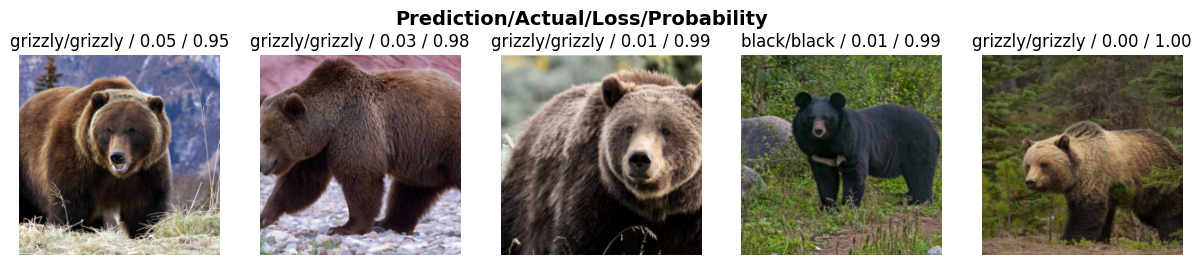

In [18]:
interp.plot_top_losses(5, nrows=1)

The intuitive approach to doing `data cleaning` is to do it before you train a model. As we have seen, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then we use it to help us with data cleaning.

Fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows one to choose a category and the training vs validation set and view the highest loss image(in order), along with menus to allow images to be selected for removal or relabeling

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export()